# **VQE Me**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Qiskit imports
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import real_amplitudes

In [ ]:
# ============================================
# 1. Define the H2 Hamiltonian (2-qubit form)
# ============================================
# These coefficients correspond to H₂ at ~0.74 Å in STO-3G
coeffs = [
    -1.052373245772859,     # II
     0.39793742484318045,   # ZI
    -0.39793742484318045,   # IZ
    -0.01128010425623538,   # ZZ
     0.18093119978423156    # XX
]
paulis = ["II", "ZI", "IZ", "ZZ", "XX"]

# Build qubit Hamiltonian using SparsePauliOp
H = SparsePauliOp.from_list(list(zip(paulis, coeffs)))
H_matrix = H.to_matrix()

# Compute true ground-state energy by diagonalization
exact_energy = float(np.linalg.eigvalsh(H_matrix).min())
print("Exact energy of H2:", exact_energy)

Exact energy of H2: -1.85727503020238


In [ ]:
# ============================================
# 2. Build a parameterized quantum ansatz
# ============================================
# RealAmplitudes is the clean, modern replacement for TwoLocal
num_qubits = 2
ansatz = real_amplitudes(num_qubits, reps=2)

In [ ]:
# Create a flat, named parameter vector matching the ansatz parameters
params = ParameterVector("θ", len(ansatz.parameters))
param_map = {p: params[i] for i, p in enumerate(ansatz.parameters)}
ansatz = ansatz.assign_parameters(param_map)

In [ ]:
# ============================================
# 3. Define the expectation value function
# ============================================
def expectation_value(theta_array):
    """Return <ψ(θ)|H|ψ(θ)> using statevector simulation."""
    # bind parameters to the ansatz circuit
    circ = ansatz.assign_parameters(theta_array)

    # obtain exact statevector
    psi = Statevector.from_instruction(circ).data

    # compute energy = <ψ|H|ψ>
    return float(np.real(np.vdot(psi, H_matrix @ psi)))

In [ ]:
# ============================================
# 4. Wrap the expectation into a cost function
# ============================================
energy_trace = []

def cost(theta):
    """Cost function tracked at each evaluation."""
    e = expectation_value(theta)
    energy_trace.append(e)
    return e

In [ ]:
# ============================================
# 5. Run VQE optimization (COBYLA)
# ============================================
np.random.seed(0)
initial_guess = 0.01 * np.random.randn(len(params))

result = minimize(
    cost,
    initial_guess,
    method="COBYLA",
    options={"maxiter": 200, "tol": 1e-6}
)

print("\nVQE estimated ground energy:", result.fun)
print("Exact (diagonalized) energy :", exact_energy)


VQE estimated ground energy: -1.8572750302022751
Exact (diagonalized) energy : -1.85727503020238


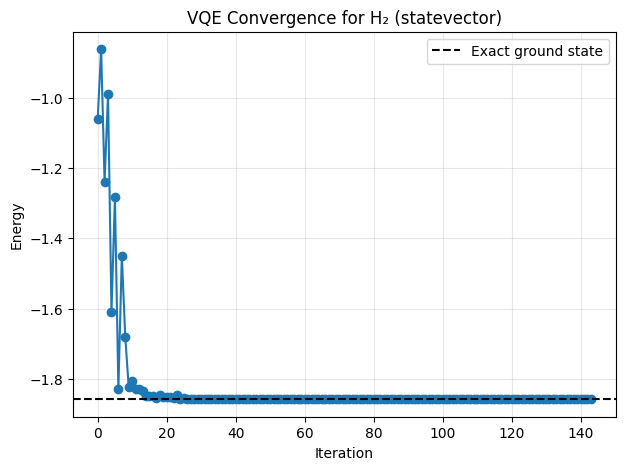

In [ ]:
# ============================================
# 6. Plot convergence
# ============================================
plt.figure(figsize=(7, 5))
plt.plot(energy_trace, marker='o', linewidth=1.5)
plt.axhline(exact_energy, color='black', linestyle='--', label="Exact ground state")
plt.title("VQE Convergence for H₂ (statevector)")
plt.xlabel("Iteration")
plt.ylabel("Energy")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [ ]:
# ============================================
# 7. Final printout
# ============================================
print("\nConverged energy difference:",
      abs(result.fun - exact_energy))


Converged energy difference: 1.0480505352461478e-13


In [ ]:
# ============================================
# 8. Exact eigen-decomposition of the Hamiltonian
# ============================================

eigvals, eigvecs = np.linalg.eigh(H_matrix)

print("Eigenvalues (ascending):")
for i, ev in enumerate(eigvals):
    print(f"  Eigenvalue {i}: {ev}")

# Ground state is eigenvector corresponding to the lowest eigenvalue
ground_energy_exact = eigvals[0]
ground_state_exact = eigvecs[:, 0]

print("\nExact ground-state energy:", ground_energy_exact)
print("Exact ground-state vector:\n", ground_state_exact)

# Pretty basis labels
basis = ["|00>", "|01>", "|10>", "|11>"]
print("\nGround-state amplitudes (exact):")
for amp, b in zip(ground_state_exact, basis):
    print(f"  {b}: {amp.real:.6f}")


Eigenvalues (ascending):
  Eigenvalue 0: -1.85727503020238
  Eigenvalue 1: -1.2445845498133257
  Eigenvalue 2: -0.8827221502448626
  Eigenvalue 3: -0.2249112528308669

Exact ground-state energy: -1.85727503020238
Exact ground-state vector:
 [ 1.12567555e-17+0.j  1.11535939e-01+0.j -9.93760401e-01+0.j
 -8.32667268e-17+0.j]

Ground-state amplitudes (exact):
  |00>: 0.000000
  |01>: 0.111536
  |10>: -0.993760
  |11>: -0.000000


In [ ]:
theta_opt = result.x

In [ ]:
# ============================================
# 9. VQE ground-state vector
# ============================================

theta_opt = result.x
circ_opt = ansatz.assign_parameters(theta_opt)

psi_vqe = Statevector.from_instruction(circ_opt).data

print("\nVQE ground-state vector:\n", psi_vqe)

print("\nGround-state amplitudes (VQE):")
for amp, b in zip(psi_vqe, basis):
    print(f"  {b}: {amp.real:.6f}")


VQE ground-state vector:
 [ 1.47994646e-07+0.j -1.11535890e-01+0.j  9.93760406e-01+0.j
  2.91349671e-07+0.j]

Ground-state amplitudes (VQE):
  |00>: 0.000000
  |01>: -0.111536
  |10>: 0.993760
  |11>: 0.000000


In [ ]:
!pip install streamlit pyngrok qiskit qiskit-aer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 60.6 MB/s eta 0:00:00


In [ ]:
from pyngrok import ngrok

# Put your token here
ngrok.set_auth_token("35YPUssKdwFZD5ncoJE4fnr9GdM_2iyqtMPQSu1defDU7yy6S")

In [ ]:
%%writefile app.py
import streamlit as st
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import real_amplitudes


# --------------------------------------------
# H2 Hamiltonian
# --------------------------------------------
coeffs = [
    -1.052373245772859,
     0.39793742484318045,
    -0.39793742484318045,
    -0.01128010425623538,
     0.18093119978423156
]
paulis = ["II", "ZI", "IZ", "ZZ", "XX"]

H = SparsePauliOp.from_list(list(zip(paulis, coeffs)))
H_matrix = H.to_matrix()

exact_energy = float(np.linalg.eigvalsh(H_matrix).min())


# --------------------------------------------
# Quantum ansatz
# --------------------------------------------
num_qubits = 2
ansatz = real_amplitudes(num_qubits, reps=2)

params = ParameterVector("θ", len(ansatz.parameters))
param_map = {p: params[i] for i, p in enumerate(ansatz.parameters)}
ansatz = ansatz.assign_parameters(param_map)


# --------------------------------------------
# Expectation value
# --------------------------------------------
def expectation_value(theta_array):
    circ = ansatz.assign_parameters(theta_array)
    psi = Statevector.from_instruction(circ).data
    return float(np.real(np.vdot(psi, H_matrix @ psi)))


# --------------------------------------------
# VQE process
# --------------------------------------------
def run_vqe():
    energy_trace = []

    def cost(theta):
        e = expectation_value(theta)
        energy_trace.append(e)
        return e

    np.random.seed(0)
    initial_guess = 0.01 * np.random.randn(len(params))

    result = minimize(
        cost,
        initial_guess,
        method="COBYLA",
        options={"maxiter": 200, "tol": 1e-6}
    )

    return result, energy_trace


# --------------------------------------------
# Streamlit UI
# --------------------------------------------
st.title("H₂ VQE Simulator (2-Qubit Version)")
st.write("Hybrid variational algorithm estimating the ground-state energy of hydrogen molecule.")

if st.button("Run VQE"):
    result, energy_trace = run_vqe()

    st.subheader("VQE Estimated Ground-State Energy")
    st.write(result.fun)

    st.subheader("Exact Ground-State Energy")
    st.write(exact_energy)

    st.subheader("Convergence Plot")
    fig, ax = plt.subplots(figsize=(7,5))
    ax.plot(energy_trace, marker='o')
    ax.axhline(exact_energy, color='black', linestyle='--', label='Exact')
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Energy")
    ax.legend()
    ax.grid(alpha=0.3)
    st.pyplot(fig)

    st.subheader("Energy Difference")
    st.write(abs(result.fun - exact_energy))


Overwriting app.py


In [ ]:

%%writefile app.py
import streamlit as st
import numpy as np
import plotly.graph_objects as go
import time
st.subheader("🧬 Interactive Molecular Orbital Visualization (H₂)")

# ---- Controls ----
orbital_type = st.radio(
    "Choose Molecular Orbital",
    ["Bonding (σ 1s)", "Antibonding (σ* 1s)"]
)

bond_length = st.slider(
    "Bond Distance (Å)",
    0.2, 2.5, 0.74, 0.01
)

density_level = st.slider(
    "Isosurface Density Level",
    0.01, 0.2, 0.06, 0.01
)

# ---- Gaussian 1s orbital function ----
def orbital_1s(x, y, z, cx, cy, cz):
    r = np.sqrt((x - cx)**2 + (y - cy)**2 + (z - cz)**2)
    return np.exp(-2 * r)   # simple hydrogen-like 1s orbital


# ---- Build 3D grid ----
grid = np.linspace(-3, 3, 40)
x, y, z = np.meshgrid(grid, grid, grid)

# Positions of atoms
A = -bond_length / 2
B =  bond_length / 2

# Atomic orbitals
phi_A = orbital_1s(x, y, z, A, 0, 0)
phi_B = orbital_1s(x, y, z, B, 0, 0)

# Molecular orbital
if orbital_type == "Bonding (σ 1s)":
    psi = phi_A + phi_B
else:
    psi = phi_A - phi_B

density = psi**2

# ---- Plotly Isosurface ----
fig = go.Figure()

# Molecular orbital isosurface
fig.add_trace(go.Isosurface(
    x=x.flatten(), y=y.flatten(), z=z.flatten(),
    value=density.flatten(),
    isomin=density_level,
    isomax=density_level * 1.1,
    caps=dict(x_show=False, y_show=False, z_show=False),
    colorscale="Teal",
    opacity=0.7,
))

# Atom positions
fig.add_trace(go.Scatter3d(
    x=[A, B], y=[0, 0], z=[0, 0],
    mode="markers",
    marker=dict(size=8, color=["cyan", "cyan"]),
    name="H atoms"
))

fig.update_layout(
    title="H₂ Molecular Orbital",
    scene=dict(
        xaxis=dict(visible=False),
        yaxis=dict(visible=False),
        zaxis=dict(visible=False)
    ),
    height=450,
    margin=dict(l=0, r=0, t=30, b=0),
)

st.plotly_chart(fig, use_container_width=True)


st.header("🔬 Advanced Quantum Visualizations")

# ============================================================
# 1) REAL 3D ATOMIC ORBITALS (1s, 2s, 2p)
# ============================================================

st.subheader("🧪 Real Atomic Orbitals (Hydrogen)")

orb_type = st.selectbox(
    "Choose Orbital",
    ["1s", "2s", "2p_x", "2p_y", "2p_z"]
)

grid = np.linspace(-4, 4, 40)
x, y, z = np.meshgrid(grid, grid, grid)

r = np.sqrt(x**2 + y**2 + z**2)
theta = np.arccos(z / (r + 1e-9))
phi = np.arctan2(y, x)

# 1s orbital
def psi_1s():
    return np.exp(-r)

# 2s orbital
def psi_2s():
    return (1 - r/2) * np.exp(-r/2)

# 2p orbitals
def psi_2p_x():
    return x * np.exp(-r/2)

def psi_2p_y():
    return y * np.exp(-r/2)

def psi_2p_z():
    return z * np.exp(-r/2)


# Select orbital
if orb_type == "1s":
    psi = psi_1s()
elif orb_type == "2s":
    psi = psi_2s()
elif orb_type == "2p_x":
    psi = psi_2p_x()
elif orb_type == "2p_y":
    psi = psi_2p_y()
else:
    psi = psi_2p_z()

density = psi**2

fig = go.Figure()
fig.add_trace(go.Isosurface(
    x=x.flatten(),
    y=y.flatten(),
    z=z.flatten(),
    value=density.flatten(),
    isomin=0.05,
    isomax=0.1,
    opacity=0.7,
    colorscale="Viridis",
    caps=dict(x_show=False, y_show=False, z_show=False)
))

fig.update_layout(
    title=f"Orbital: {orb_type}",
    height=400,
    scene=dict(
        xaxis=dict(visible=False),
        yaxis=dict(visible=False),
        zaxis=dict(visible=False)
    )
)
st.plotly_chart(fig, use_container_width=True)


# ============================================================
# 3) INTERACTIVE H₂ BOND LENGTH VIEWER (REAL-TIME 3D)
# ============================================================

st.subheader("🔗 Interactive H₂ Bond Length Visualization")

bond_len_slider = st.slider(
    "Adjust H–H Bond Length (Å)",
    0.2, 3.0, 0.74, 0.01
)

# Hydrogen atom positions
xa = -bond_len_slider / 2
xb =  bond_len_slider / 2

# Create live interactive 3D plot
figH2 = go.Figure()

# Atoms (points)
figH2.add_trace(go.Scatter3d(
    x=[xa, xb],
    y=[0, 0],
    z=[0, 0],
    mode="markers",
    marker=dict(size=12, color=["cyan", "cyan"]),
    name="Hydrogen Atoms"
))

# Bond (cylinder-like thick line)
figH2.add_trace(go.Scatter3d(
    x=[xa, xb],
    y=[0, 0],
    z=[0, 0],
    mode="lines",
    line=dict(color="cyan", width=10),
    name="Bond"
))

figH2.update_layout(
    title=f"H₂ Molecule – Bond Length: {bond_len_slider:.2f} Å",
    height=400,
    scene=dict(
        xaxis=dict(visible=False),
        yaxis=dict(visible=False),
        zaxis=dict(visible=False),
        aspectmode="data"
    ),
    showlegend=False
)

st.plotly_chart(figH2, use_container_width=True)
# ============================================================
# 4) INTERACTIVE BLOCH SPHERES FOR QUBITS
# ============================================================

st.subheader("🧭 Interactive Bloch Spheres (Qubit State Viewer)")

theta = st.slider("θ (polar angle)", 0.0, np.pi, np.pi/3)
phi = st.slider("φ (azimuth)", 0.0, 2*np.pi, np.pi/4)

# Bloch sphere coordinates
bx = np.sin(theta) * np.cos(phi)
by = np.sin(theta) * np.sin(phi)
bz = np.cos(theta)

theta2 = st.slider("θ₂ (qubit 2)", 0.0, np.pi, np.pi/2)
phi2 = st.slider("φ₂ (qubit 2)", 0.0, 2*np.pi, np.pi/6)

bx2 = np.sin(theta2) * np.cos(phi2)
by2 = np.sin(theta2) * np.sin(phi2)
bz2 = np.cos(theta2)

fig3 = go.Figure()

# Sphere
u = np.linspace(0, 2*np.pi, 50)
v = np.linspace(0, np.pi, 25)
xs = np.outer(np.cos(u), np.sin(v))
ys = np.outer(np.sin(u), np.sin(v))
zs = np.outer(np.ones_like(u), np.cos(v))

fig3.add_trace(go.Surface(
    x=xs, y=ys, z=zs,
    colorscale="Blues", opacity=0.2, showscale=False
))

# Qubit 1 vector
fig3.add_trace(go.Scatter3d(
    x=[0, bx], y=[0, by], z=[0, bz],
    mode="lines+markers",
    line=dict(color="cyan", width=6),
    marker=dict(size=4, color='cyan')
))

# Qubit 2 vector
fig3.add_trace(go.Scatter3d(
    x=[0, bx2], y=[0, by2], z=[0, bz2],
    mode="lines+markers",
    line=dict(color="magenta", width=6),
    marker=dict(size=4, color='magenta')
))

fig3.update_layout(
    title="Bloch Sphere (Qubit States)",
    height=450,
    scene=dict(
        xaxis=dict(visible=False),
        yaxis=dict(visible=False),
        zaxis=dict(visible=False)
    )
)

st.plotly_chart(fig3, use_container_width=True)



Overwriting app.py


In [ ]:
!nohup streamlit run app.py --server.port 8501 &

# create public URL
public_url = ngrok.connect(8501)
public_url

nohup: appending output to 'nohup.out'


<NgrokTunnel: "https://reconcilable-brachydactylic-myrna.ngrok-free.dev" -> "http://localhost:8501">